# Probabilistic Reasoning over Time
---
# Finding the Most Likely Sequence with Viterbi Algorithm

## Introduction
An ***Hidden Markov Model*** (HMM) network is parameterized by two distributions:

- the *emission or sensor probabilties* giving the conditional probability of observing evidence values for each hidden state;
- the *transition probabilities* giving the conditional probability of moving between states during the sequence. 

Additionally, an *initial distribution* describes the probability of a sequence starting in each state.

At each time $t$, $X_t$ represents the *hidden state* and $E_t$ represents an *observation* at that time.

In [6]:
from probability import *

In [7]:
%psource HiddenMarkovModel

class HiddenMarkovModel:
    """A Hidden markov model which takes Transition model and Sensor model as inputs"""

    def __init__(self, transition_model, sensor_model, prior=None):
        self.transition_model = transition_model
        self.sensor_model = sensor_model
        self.prior = prior or [0.5, 0.5]

    def sensor_dist(self, ev):
        if ev is True:
            return self.sensor_model[0]
        else:
            return self.sensor_model[1]


## Finding the Most Likely Sequence

There is a linear-time algorithm for finding the most likely sequence: the easiest way to think about the problem is to view each sequence as a path through a graph whose nodes are the possible states at each time step. Now consider the task of finding the most likely path through this graph, where the likelihood of any path is the product of the transition probabilities along the path and the probabilities of the given observations at each state. There is a recursive relationship between most likely paths to each state $x_{t+1}$ and most likely paths to each state $x_t$ . We can write this relationship as an equation connecting the probabilities of the paths:

$$ 
\begin{align*}
m_{1:t+1} &= \max_{x_{1:t}} \textbf{P}(\textbf{x}_{1:t}, \textbf{X}_{t+1} | \textbf{e}_{1:t+1}) \\
&= \alpha \textbf{P}(\textbf{e}_{t+1} | \textbf{X}_{t+1}) \max_{x_t} \Big(\textbf{P}
(\textbf{X}_{t+1} | \textbf{x}_t) \max_{x_{1:t-1}} P(\textbf{x}_{1:t-1}, \textbf{x}_{t} | \textbf{e}_{1:t})\Big)
\end{align*}
$$

The *Viterbi algorithm* is a dynamic programming algorithm for *finding the most likely sequence of hidden states*, called the Viterbi path, that results in a sequence of observed events in the context of HMMs.
This algorithms is useful in many applications, including *speech recognition*, where the aim is to find the most likely sequence of words, given a series of sounds and the *reconstruction of bit strings transmitted over a noisy channel*.

In [8]:
%psource viterbi

def viterbi(HMM, ev):
    """
    [Equation 15.11]
    Viterbi algorithm to find the most likely sequence. Computes the best path and the
    corresponding probabilities, given an HMM model and a sequence of observations."""
    t = len(ev)
    ev = ev.copy()
    ev.insert(0, None)

    m = [[0.0, 0.0] for _ in range(len(ev) - 1)]

    # the recursion is initialized with m1 = forward(P(X0), e1)
    m[0] = forward(HMM, HMM.prior, ev[1])
    # keep track of maximizing predecessors
    backtracking_graph = []

    for i in range(1, t):
        m[i] = element_wise_product(HMM.sensor_dist(ev[i + 1]),
                                    [max(element_wise_product(HMM.transition_model[0], m[i - 1])),
                                     max(element_wise_product(HMM.transition_model[1], m[i - 1]))])
        backtracking_graph.append([np.argmax(element_wise_product(HMM.transition_model[0], m[i - 1])),
                                   np.argmax(element_wise_product(HMM.transition_model[1], m[i 

### Umbrella World
---

> You are the security guard stationed at a secret under-ground installation. Each day, you try to guess whether it’s raining today, but your only access to the outside world occurs each morning when you see the director coming in with, or without, an umbrella.

In this problem $t$ corresponds to each day of the week, the hidden state $X_t$ represent the *weather* outside at day $t$ (whether it is rainy or sunny) and observations record $E_t$ whether at day $t$ the security guard sees the director carrying an *umbrella* or not.

#### Observation Emission or Sensor Probabilities $P(E_t := Umbrella_t | X_t := Weather_t)$
We need to assume that we have some prior knowledge about the director's behavior to estimate the emission probabilities for each hidden state:

| |  $yes$  | $no$ |
| --- | --- | --- |
| $Sunny$ |   0.10  | 0.90 |
| $Rainy$ | 0.80 | 0.20 |

#### Initial Probability $P(X_0 := Weather_0)$
We will assume that we don't know anything useful about the likelihood of a sequence starting in either state. If the sequences start each week on Monday and end each week on Friday (so each week is a new sequence), then this assumption means that it's equally likely that the weather on a Monday may be Rainy or Sunny. We can assign equal probability to each starting state:

| $Sunny$ | $Rainy$ |
| --- | ---
| 0.5 | 0.5 |

#### State Transition Probabilities $P(X_{t} := Weather_t | X_{t-1} := Weather_{t-1})$
Finally, we will assume that we can estimate transition probabilities from something like historical weather data for the area. Under this assumption, we get the conditional probability:

| |     $Sunny$ | $Rainy$ |
| --- | --- | --- |
|$Sunny$| 0.70 | 0.30 |
|$Rainy$| 0.30 | 0.70 |

In [9]:
umbrella_transition = [[0.7, 0.3], [0.3, 0.7]]
umbrella_sensor = [[0.9, 0.2], [0.1, 0.8]]
umbrellaHMM = HiddenMarkovModel(umbrella_transition, umbrella_sensor)

In [10]:
from graphviz import Digraph

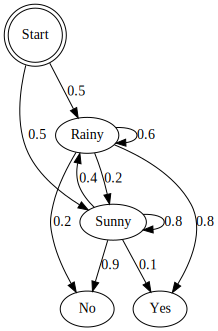

In [11]:
dot = Digraph()

dot.node('I', 'Start', shape='doublecircle')
dot.node('R', 'Rainy')
dot.node('S','Sunny')

dot.edge('I', 'R', label='0.5')
dot.edge('I', 'S', label='0.5')

dot.edge('R', 'S', label='0.2')
dot.edge('S', 'R', label='0.4')

dot.node('Y', 'Yes')
dot.node('N', 'No')

dot.edge('R', 'R', label='0.6')
dot.edge('R', 'Y', label='0.8')
dot.edge('R', 'N', label='0.2')

dot.edge('S', 'S', label='0.8')
dot.edge('S', 'Y', label='0.1')
dot.edge('S', 'N', label='0.9')

dot

Suppose that $[true, true, false, true, true]$ is the umbrella sequence for the security guard’s first five days on the job. What is the weather sequence most likely to explain this?

In [12]:
from utils import rounder

In [14]:
umbrella_evidence = [True, True, False, True, True]

rounder(viterbi(umbrellaHMM, umbrella_evidence))

([1, 1, 0, 1, 1], [0.8182, 0.5155, 0.1237, 0.0334, 0.021])